In [2]:
from skimage.metrics import normalized_root_mse as NRMSE
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import scipy.io as scio
import time
physical_devices = tf.config.list_physical_devices()
for dev in physical_devices:
    print(dev)

print("tf version:", tf.__version__)

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
tf version: 2.13.1


In [3]:


def calculate_diff_rgb(images_true, images_test, normalization='min-max'):
    diffs = []
    for (img_true, img_test) in (zip(images_true, images_test)):
        diff = NRMSE(img_true, img_test, normalization=normalization)
        diffs.append(diff)
    return np.array(diffs)


def plot_results(y_design, ytarg_rev, Xtarg):
    NRMSE_diff = calculate_diff_rgb(ytarg_rev, y_design)
    fig = plt.figure()
    ax = plt.subplot(111)
    _ = ax.hist(NRMSE_diff, bins=20, color="skyblue", edgecolor="black")
    ax.set_xlabel("NRMSE")
    ax.set_ylabel("Frequency")
    id_sort = np.argsort(NRMSE_diff)
    YY_de = y_design
    fig = plt.figure(figsize=(8, 3))
    ax = plt.subplot(1, 5, 1)
    ax.imshow(ytarg_rev[0])
    ax.axis('scaled')
    ax.axis('off')
    ax.set_title('Target')
    ax = plt.subplot(1, 5, 2)
    idx = id_sort[0]
    ax.imshow(YY_de[idx])
    ax.axis('scaled')
    ax.axis('off')
    ax.set_title(r'NRMSE=%.2f' % NRMSE_diff[idx])
    ax = plt.subplot(1, 5, 3)
    idx = id_sort[int(id_sort.shape[0]*0.3)]
    ax.imshow(YY_de[idx])
    ax.axis('scaled')
    ax.axis('off')
    ax.set_title(r'NRMSE=%.2f' % NRMSE_diff[idx])
    ax = plt.subplot(1, 5, 4)
    idx = id_sort[int(id_sort.shape[0]*0.6)]
    ax.imshow(YY_de[idx])
    ax.axis('scaled')
    ax.axis('off')
    ax.set_title(r'NRMSE=%.2f' % NRMSE_diff[idx])
    ax = plt.subplot(1, 5, 5)
    idx = id_sort[-1]
    ax.imshow(YY_de[idx])
    ax.axis('scaled')
    ax.axis('off')
    ax.set_title(r'NRMSE=%.2f' % NRMSE_diff[idx])
    plt.tight_layout()
    fig = plt.figure(figsize=(8, 3), constrained_layout=True)
    ax = plt.subplot(1, 2, 1)
    ax.set_ylabel(r'$\alpha_0~[\%]$')
    ax.set_xlabel(r'$T_0~[^oC]$')
    sc = ax.scatter(x_design[:, 0], x_design[:, 1]*100,
                    c=NRMSE_diff, cmap='summer', s=10)
    ax.scatter(Xtarg[:, 0], Xtarg[:, 1]*100, c='r',
               marker='*', s=20, label='target')
    ax.scatter(x_design[id_sort[0], 0], x_design[id_sort[0], 1]
               * 100, c='b', marker='^', s=20, label='best')
    ax.legend()
    ax = plt.subplot(1, 2, 2)
    ax.set_ylabel(r'$d$')
    ax.set_xlabel(r'$h_L~[\frac{W}{K m^2}]$')
    sc = ax.scatter(x_design[:, 2], x_design[:, 3],
                    c=NRMSE_diff, cmap='summer', s=10)
    ax.scatter(Xtarg[:, 2], Xtarg[:, 3], c='r',
               marker='*', s=20, label='target')
    ax.scatter(x_design[id_sort[0], 2], x_design[id_sort[0], 3],
               c='b', marker='^', s=20, label='best')
    ax.legend()
    cbar = plt.colorbar(sc)
    cbar.set_label('NRMSE')



In [4]:
data_path = './training_data'
data_mat = scio.loadmat(
    (os.path.join(data_path, "data64X64(75-125mm)(393-503K)ln1+gs1.mat")))
input_data_raw = data_mat['input']
input_data = input_data_raw
out_data = data_mat['output']

In [5]:
min_max_in = MinMaxScaler(feature_range=(0, 1))
input_norm = min_max_in.fit_transform(input_data)
min_out, max_out = np.min(out_data), np.max(out_data)
out_norm = (out_data/127.5)-1.0

X_train, X_test, Y_train, Y_test = train_test_split(
    input_norm, out_norm, test_size=0.2, random_state=402)


Y_train_rev = (Y_train+1)*127.5
Y_test_rev = (Y_test+1)*127.5
Y_train_rev = Y_train_rev.astype(np.uint8)
Y_test_rev = Y_test_rev.astype(np.uint8)


In [6]:


@keras.saving.register_keras_serializable(name="attention_layer")
class AttentionBlock(layers.Layer):
    """Applies self-attention.

    Args:
        units: Number of units in the dense layers
        groups: Number of groups to be used for GroupNormalization layer
    """

    def __init__(self, units, groups=8, **kwargs):
        self.units = units
        self.groups = groups
        super().__init__(**kwargs)

        self.norm = layers.GroupNormalization(groups=groups)
        self.query = layers.Dense(units)
        self.key = layers.Dense(units)
        self.value = layers.Dense(units)
        self.proj = layers.Dense(units)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        height = tf.shape(inputs)[1]
        width = tf.shape(inputs)[2]
        scale = tf.cast(self.units, tf.float32) ** (-0.5)

        inputs = self.norm(inputs)  # b*h*w*unit
        q = self.query(inputs)
        k = self.key(inputs)
        v = self.value(inputs)
        # equivalent: [hw X C] * [hw X C]^T, eliminate the index of c
        attn_score = tf.einsum("bhwc, bHWc->bhwHW", q, k) * scale
        attn_score = tf.reshape(
            attn_score, [batch_size, height, width, height * width])

        attn_score = tf.nn.softmax(attn_score, -1)
        attn_score = tf.reshape(
            attn_score, [batch_size, height, width, height, width])
        # equivalent: [hw X hw] * [hw X c]
        # how to use attention layer for imags
        proj = tf.einsum("bhwHW,bHWc->bhwc", attn_score, v)
        proj = self.proj(proj)
        return inputs + proj


@keras.saving.register_keras_serializable(name="resiBlock")
class ResidualBlock(layers.Layer):
    """Residual block.

    Args:
        channel: Number of channels in the convolutional layers
        groups: Number of groups to be used for GroupNormalization layer
        activation_fn: Activation function to be used
    """

    def __init__(self, channel, groups=8, activation_fn=keras.activations.swish, **kwargs):
        self.channel = channel
        self.groups = groups
        self.activation_fn = activation_fn
        super().__init__(**kwargs)
        self.shortcut = layers.Conv2D(channel, kernel_size=1)
        self.norm1 = layers.GroupNormalization(
            groups=groups)  # layers.BatchNormalization()#

        self.conv1 = layers.Conv2D(channel, kernel_size=3, padding="same")
        self.norm2 = layers.GroupNormalization(
            groups=groups)  # layers.BatchNormalization()#
        self.conv2 = layers.Conv2D(channel, kernel_size=3, padding="same")
        self.addlayer = layers.Add()

    def call(self, inputs):
        x = inputs
        input_c = x.shape[3]
        if input_c == self.channel:
            residual = x
        else:
            residual = self.shortcut(x)
        x = self.norm1(x)
        x = self.activation_fn(x)
        x = self.conv1(x)
        x = self.norm2(x)
        x = self.activation_fn(x)
        x = self.conv2(x)
        x = self.addlayer([x, residual])
        return x

    def get_config(self):
        # Get the base config from the superclass
        config = super().get_config()
        # Update it with the custom arguments
        config.update({
            "groups": self.groups,
            "channel": self.channel,
        })
        return config


@keras.saving.register_keras_serializable(name="DownSample")
class DownSample(layers.Layer):
    def __init__(self, channel, **kwargs):
        self.channel = channel
        super().__init__(**kwargs)
        self.conv = layers.Conv2D(
            channel, kernel_size=3, strides=2, padding="same"
        )

    def call(self, inputs):
        return self.conv(inputs)


@keras.saving.register_keras_serializable(name="UpSample")
class UpSample(layers.Layer):
    def __init__(self, channel, interpolation="nearest", **kwargs):
        self.channel = channel
        self.interpolation = interpolation
        super().__init__(**kwargs)
        self.upsample = layers.UpSampling2D(
            size=2, interpolation=interpolation)
        self.conv = layers.Conv2D(
            channel, kernel_size=3, padding="same"
        )

    def call(self, inputs):
        x = self.upsample(inputs)
        x = self.conv(x)
        return x


forw_filebase = './saved_model/forward_model/'
model = tf.keras.models.load_model(os.path.join(
    forw_filebase, 'saved_model.keras'), compile=False)


2025-01-31 00:48:54.794542: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38366 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:07:00.0, compute capability: 8.0


In [7]:


def split_model(model):
    x1 = keras.Input(shape=(1,))
    x2 = keras.Input(shape=(1,))
    x3 = keras.Input(shape=(1,))
    x4 = keras.Input(shape=(1,))
    x = tf.concat([x1, x2, x3, x4], 1)
    out = model(x)
    new_model = tf.keras.Model([x1, x2, x3, x4], out, name="split_model")
    return new_model


my_model = split_model(model)
my_model.summary()



Model: "split_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                        

In [8]:
# %%

In [9]:
loss_object = tf.keras.losses.MeanSquaredError()


class TrainStep(tf.Module):
    def __init__(self, optimizer):
        self.optimizer = optimizer

    @tf.function
    def __call__(self, ytarg, x_vars):
        with tf.GradientTape() as g:
            # Ensure my_model is correctly defined
            f = loss_object(ytarg, my_model(x_vars))
        gradients = g.gradient(f, x_vars)
        self.optimizer.apply_gradients(zip(gradients, x_vars))
        return f, gradients


def fit(ytarg, x_vars, train_step, epoches=200, tol_grad=1e-3, tol=1e-2, x_targ=None):
    for i in range(epoches):
        f, gradients = train_step(ytarg, x_vars)
        # grad = np.array([i.numpy()[0][0] for i in gradients])
        # grad = np.mean(np.abs(grad))
        if (i+1) % 500 == 0:
            x_vars_np = [x.numpy()[0] for x in x_vars]
            print(f'>>> {i}-th loss {f.numpy():.2e}, x: {x_vars_np}')
    return f



In [10]:
test_id = 241
ytarg = Y_test[test_id, :][None]
Xtarg = X_test[test_id, :][None]
Xtarg = min_max_in.inverse_transform(Xtarg)

>>> 0-th trial


2025-01-31 00:49:03.452108: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-01-31 00:49:03.536665: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8900
2025-01-31 00:49:05.365733: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f1247aaac60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-31 00:49:05.365759: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-01-31 00:49:05.401890: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-31 00:49:05.710100: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pro

>>> 499-th loss 2.11e-01, x: [array([1.03540546]), array([0.63153151]), array([0.18334399]), array([-0.12944186])]
>>> 999-th loss 2.11e-01, x: [array([1.03513233]), array([0.63075911]), array([0.18346368]), array([-0.12879655])]
>>> 1-th trial
>>> 499-th loss 4.30e-01, x: [array([0.06356414]), array([0.75581326]), array([0.13023798]), array([0.64721093])]
>>> 999-th loss 4.30e-01, x: [array([0.06332556]), array([0.75602278]), array([0.13019808]), array([0.64779253])]
>>> 2-th trial
>>> 499-th loss 4.16e-01, x: [array([0.07290949]), array([0.5467562]), array([0.86296453]), array([0.10830596])]
>>> 999-th loss 4.16e-01, x: [array([0.06955202]), array([0.54682476]), array([0.86582298]), array([0.10922011])]
>>> 3-th trial
>>> 499-th loss 2.17e-01, x: [array([0.54198018]), array([0.44902879]), array([0.54436479]), array([0.81077703])]
>>> 999-th loss 2.17e-01, x: [array([0.54210165]), array([0.44843616]), array([0.54358162]), array([0.8114683])]
>>> 4-th trial
>>> 499-th loss 4.65e-01, x:

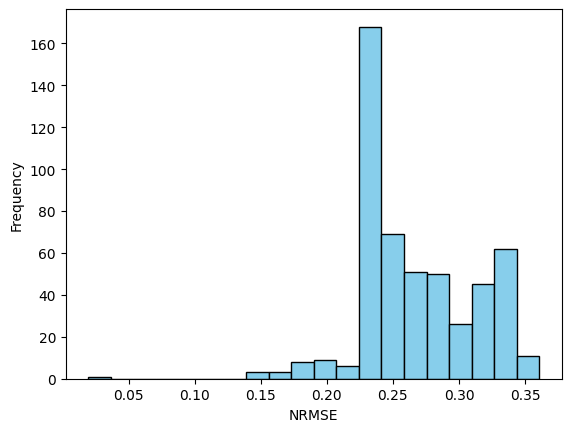

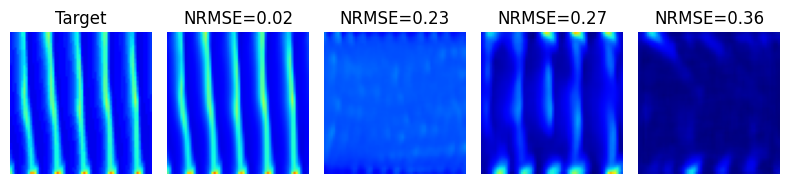

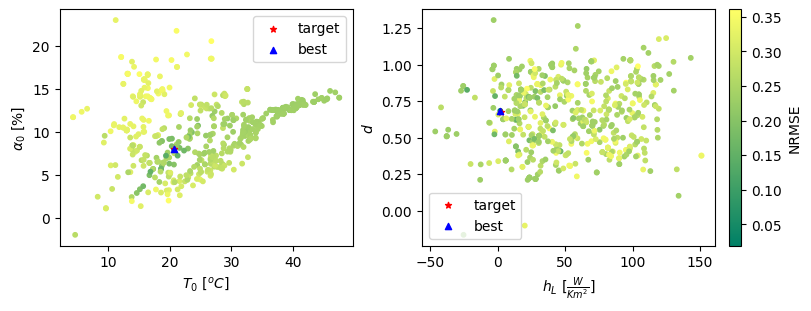

In [11]:
# random initial guess x0
solutions = []
start = time.time()
for numIte in range(512):
    print(f'>>> {numIte}-th trial')
    x0 = np.random.rand(1, 4)
    x_vars = [tf.Variable(x0[0:1, i:i+1]) for i in range(4)]
    opt1 = tf.keras.optimizers.Adam(learning_rate=1e-2)
    train_o1 = TrainStep(opt1)
    loss = fit(
        ytarg, x_vars, train_o1, epoches=1000, tol=1e-2)
    solutions.append(x_vars)
end = time.time()
print(f'>>> time elapsed: {end-start}')
solution_np = np.array([np.array([x[i].numpy()[0]
                       for i in range(4)]) for x in solutions]).squeeze()
x_design = min_max_in.inverse_transform(solution_np)
ypred = np.array([my_model(x)[0].numpy() for x in solutions])
y_design = (ypred+1)*127.5
y_design = y_design.astype(np.uint8)
ytarg_rev = Y_test_rev[test_id][None].repeat(y_design.shape[0], axis=0)
plot_results(y_design, ytarg_rev, Xtarg)


>>> 0-th trial
>>> 499-th loss 2.90e-02, x: [array([0.34602129]), array([0.34417294]), array([-0.09324063]), array([0.64914977])]
>>> 999-th loss 2.95e-02, x: [array([0.34746744]), array([0.34320117]), array([-0.09406145]), array([0.64954562])]
>>> 1-th trial
>>> 499-th loss 2.08e-01, x: [array([0.95584975]), array([0.71614096]), array([-0.57322647]), array([0.98699376])]
>>> 999-th loss 2.08e-01, x: [array([0.95596231]), array([0.7164488]), array([-0.57350914]), array([0.98561407])]
>>> 2-th trial
>>> 499-th loss 3.12e-01, x: [array([0.19726063]), array([-0.10519228]), array([-0.04118222]), array([-0.41562336])]
>>> 999-th loss 3.04e-01, x: [array([0.19857969]), array([-0.05490382]), array([0.00072681]), array([-0.40626447])]
>>> 3-th trial
>>> 499-th loss 4.62e-01, x: [array([-0.20966454]), array([0.5208662]), array([0.70294794]), array([0.94722872])]
>>> 999-th loss 4.63e-01, x: [array([-0.20939163]), array([0.52211222]), array([0.70250093]), array([0.94500734])]
>>> 4-th trial
>>> 

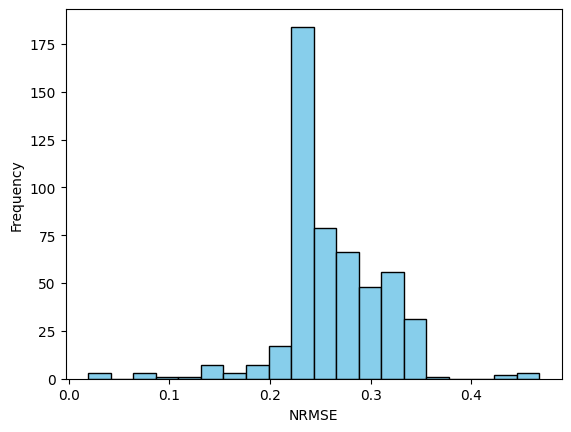

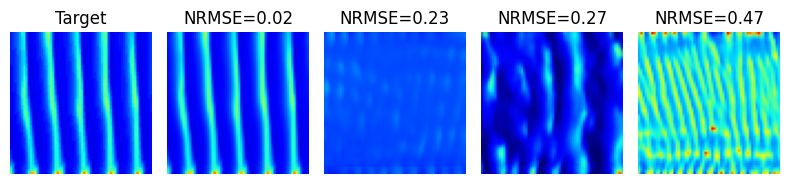

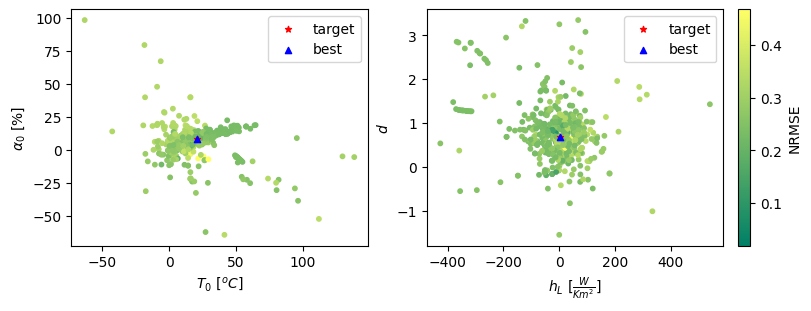

In [12]:
# initial guess x0=x_targ+eps
start = time.time()
solutions = []
for numIte in range(512):
    print(f'>>> {numIte}-th trial')
    eps = np.random.normal(size=(1, 4), scale=0.5)
    x0 = X_test[test_id][None, :]+eps
    x_vars = [tf.Variable(x0[0:1, i:i+1]) for i in range(4)]
    opt1 = tf.keras.optimizers.Adam(learning_rate=1e-2)
    train_o1 = TrainStep(opt1)
    loss = fit(
        ytarg, x_vars, train_o1, epoches=1000, tol=1e-2)
    solutions.append(x_vars)
end = time.time()
print(f'>>> time elapsed: {end-start}')
solution_np = np.array([np.array([x[i].numpy()[0]
                       for i in range(4)]) for x in solutions]).squeeze()
x_design = min_max_in.inverse_transform(solution_np)
ypred = np.array([my_model(x)[0].numpy() for x in solutions])
y_design = (ypred+1)*127.5
y_design = y_design.astype(np.uint8)
ytarg_rev = Y_test_rev[test_id][None].repeat(y_design.shape[0], axis=0)
plot_results(y_design, ytarg_rev, Xtarg)
